In [248]:
import sys
from datetime import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from scipy.stats import norm

In [4]:
print(sys.version)
plt.style.use("seaborn-dark")

3.7.0 (v3.7.0:1bf9cc5093, Jun 26 2018, 23:26:24) 
[Clang 6.0 (clang-600.0.57)]


In [23]:
df_wti_raw = pd.read_csv(
    "../data/fred/DCOILWTICO.csv",
    index_col=0,
    header=0,
    parse_dates=["DATE"],
    date_parser=lambda d: datetime.strptime(d, "%Y-%m-%d")
)
df_cpi_raw = pd.read_csv(
    "../data/fred/CPIAUCSL.csv",
    index_col=0,
    header=0,
    parse_dates=["DATE"],
    date_parser=lambda d: datetime.strptime(d, "%Y-%m-%d")
)

In [124]:
start = datetime(2000, 1, 1)
end = datetime(2019, 9, 30)
def select_range(df):
    return df[np.logical_and(
        df.index >= start, df.index <= end
    )]
df_wti, df_cpi = map(select_range, (df_wti_raw, df_cpi_raw))
df_wti = df_wti[df_wti.values != "."]
df_wti, df_cpi = map(lambda x: x.astype(np.float32), (df_wti, df_cpi))

In [125]:
print(df_wti.info())
print(df_wti.head())
print(df_wti.tail())
print(df_cpi.info())
print(df_cpi.head())
print(df_cpi.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4956 entries, 2000-01-04 to 2019-09-30
Data columns (total 1 columns):
DCOILWTICO    4956 non-null float32
dtypes: float32(1)
memory usage: 58.1 KB
None
            DCOILWTICO
DATE                  
2000-01-04   25.559999
2000-01-05   24.650000
2000-01-06   24.790001
2000-01-07   24.790001
2000-01-10   24.709999
            DCOILWTICO
DATE                  
2019-09-24   57.220001
2019-09-25   56.380001
2019-09-26   56.240002
2019-09-27   55.950001
2019-09-30   54.090000
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 237 entries, 2000-01-01 to 2019-09-01
Data columns (total 1 columns):
CPIAUCSL    237 non-null float32
dtypes: float32(1)
memory usage: 2.8 KB
None
              CPIAUCSL
DATE                  
2000-01-01  169.300003
2000-02-01  170.000000
2000-03-01  171.000000
2000-04-01  170.899994
2000-05-01  171.199997
              CPIAUCSL
DATE                  
2019-05-01  255.154999
2019-06-01  255.304993
2019-07-01  256.16

In [163]:
# Normalizing using CPIAUCSL to construct real crude oil price.
# Creating CPI referencing series
df_norm_cpi = df_cpi / df_cpi.iloc[0, 0]  # 2000.01.01 as 1.00 index.
df_norm_cpi_daily = df_norm_cpi.resample("d", fill_method="ffill", label="left")
# fig = plt.figure(figsize=(15, 3), dpi=300)
# plt.scatter(df_norm_cpi.index, df_norm_cpi.values, label="monthly", alpha=0.7, s=1, color="red")
# plt.plot(df_norm_cpi_daily, label="daily", alpha=0.3)
# plt.legend()
# plt.show()
df_norm_cpi = df_norm_cpi_daily

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7184 entries, 2000-01-01 to 2019-09-01
Freq: D
Data columns (total 1 columns):
CPIAUCSL    7184 non-null float32
dtypes: float32(1)
memory usage: 84.2 KB


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: fill_method is deprecated to .resample()
the new syntax is .resample(...).ffill()
  after removing the cwd from sys.path.


In [180]:
# Normalize operation, sequential implementation.
df_wti_real = pd.DataFrame(columns=["DCOILWTICO_REAL"], index=df_wti.index).astype(np.float32)
for t in df_wti_real.index:
    try:
        real_price = df_wti["DCOILWTICO"][t] / df_norm_cpi["CPIAUCSL"][t]
        df_wti_real["DCOILWTICO_REAL"][t] = real_price
    except KeyError:
        print(f"Skipped: {t}")

Skipped: 2019-09-03 00:00:00
Skipped: 2019-09-04 00:00:00
Skipped: 2019-09-05 00:00:00
Skipped: 2019-09-06 00:00:00
Skipped: 2019-09-09 00:00:00
Skipped: 2019-09-10 00:00:00
Skipped: 2019-09-11 00:00:00
Skipped: 2019-09-12 00:00:00
Skipped: 2019-09-13 00:00:00
Skipped: 2019-09-16 00:00:00
Skipped: 2019-09-17 00:00:00
Skipped: 2019-09-18 00:00:00
Skipped: 2019-09-19 00:00:00
Skipped: 2019-09-20 00:00:00
Skipped: 2019-09-23 00:00:00
Skipped: 2019-09-24 00:00:00
Skipped: 2019-09-25 00:00:00
Skipped: 2019-09-26 00:00:00
Skipped: 2019-09-27 00:00:00
Skipped: 2019-09-30 00:00:00


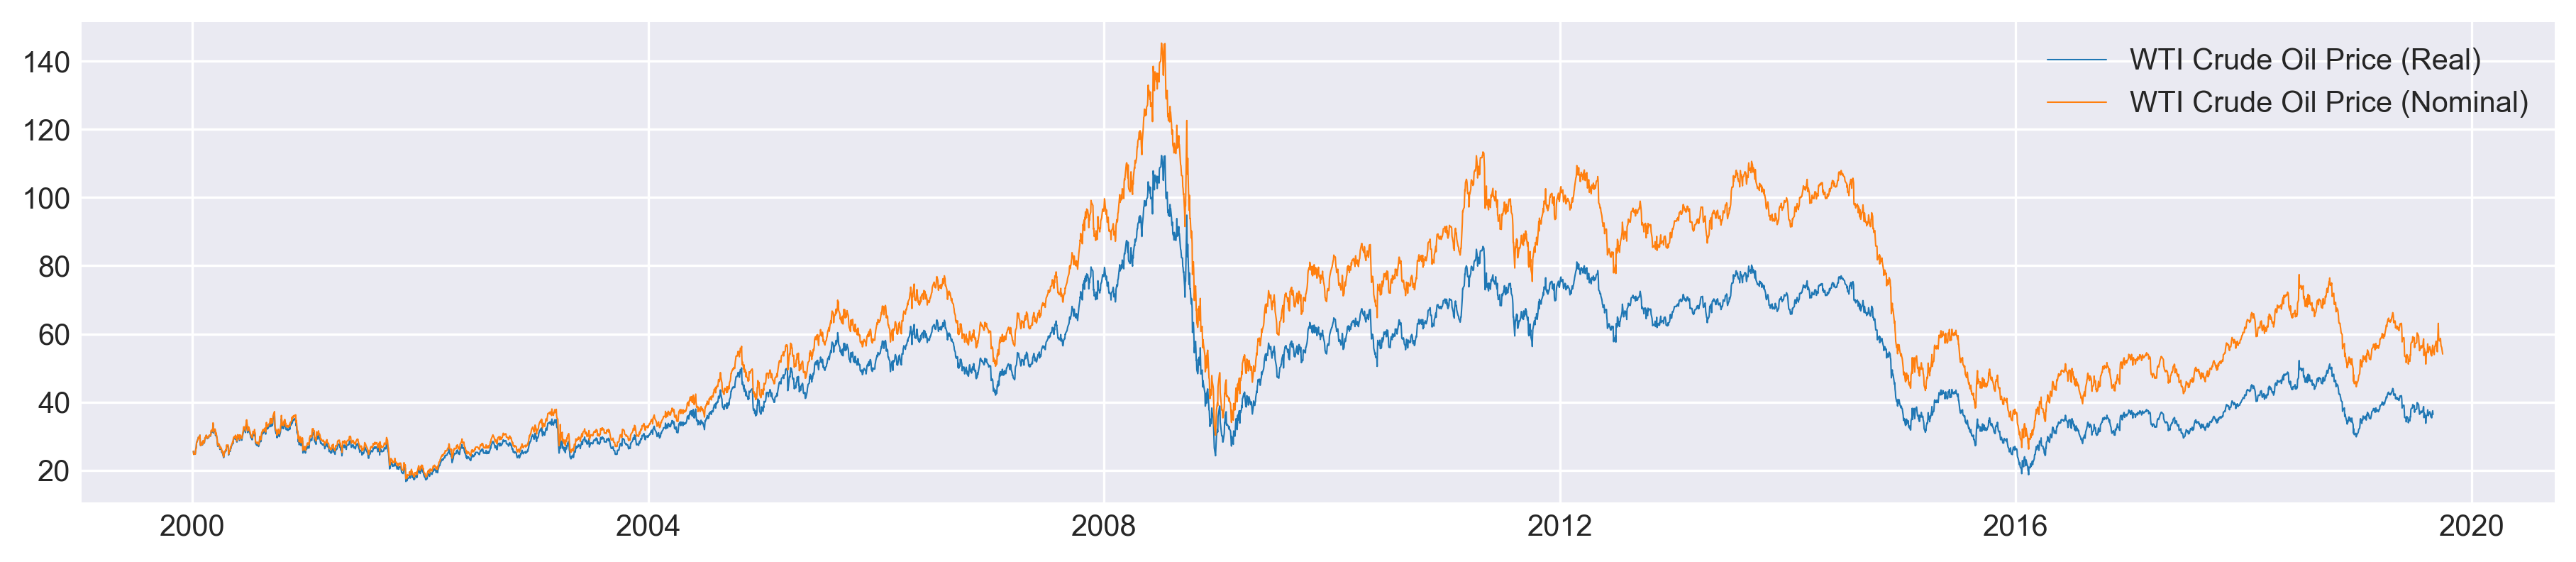

In [246]:
plt.rcParams["figure.figsize"] = (15, 3)
plt.rcParams["figure.dpi"] = 300
plt.rcParams["axes.grid"] = True
plt.plot(df_wti_real, linewidth=0.5, label="WTI Crude Oil Price (Real)")
plt.plot(df_wti, linewidth=0.5, label="WTI Crude Oil Price (Nominal)")
plt.legend()
plt.show()

In [252]:
# Transform to log-difference (return)
def construct_return(raw_price: pd.DataFrame):
    log_price = np.log(raw_price).dropna()
    return log_price.diff().dropna()

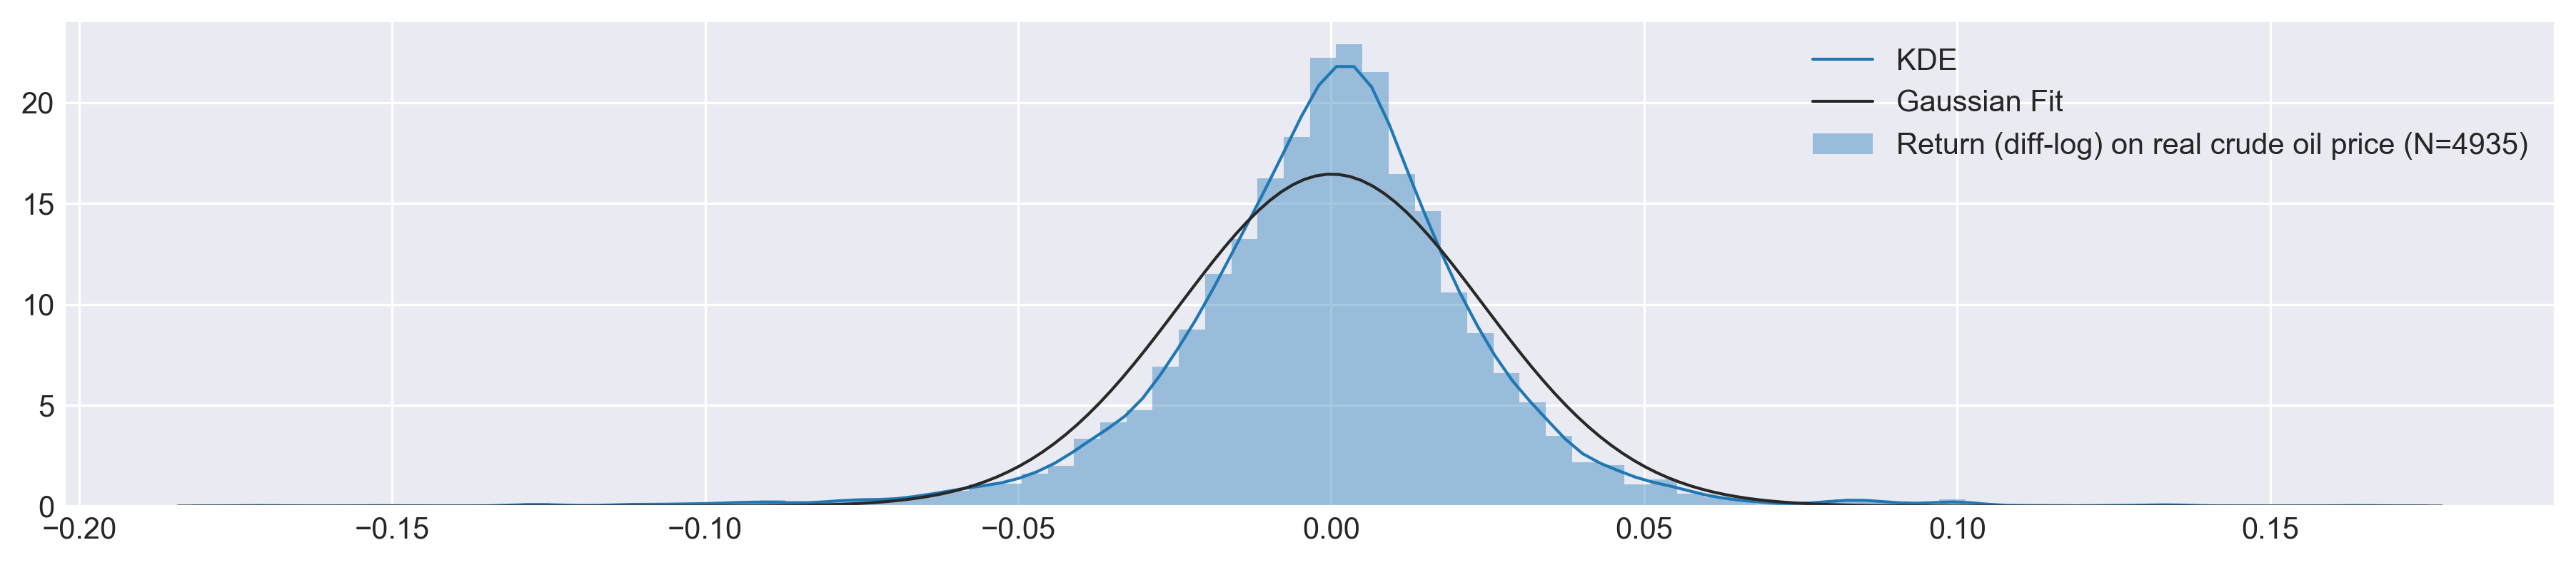

In [259]:
df_wti_return = construct_return(df_wti_real)
sns.distplot(
    df_wti_return.values,
    bins=80,
    fit=norm,
    fit_kws={"lw": 1, "label": "Gaussian Fit"},
    kde=True,
    kde_kws={"lw": 1, "label": "KDE"},
    label=f"Return (diff-log) on real crude oil price (N={len(df_wti_return.values)})")
plt.legend()
plt.show()

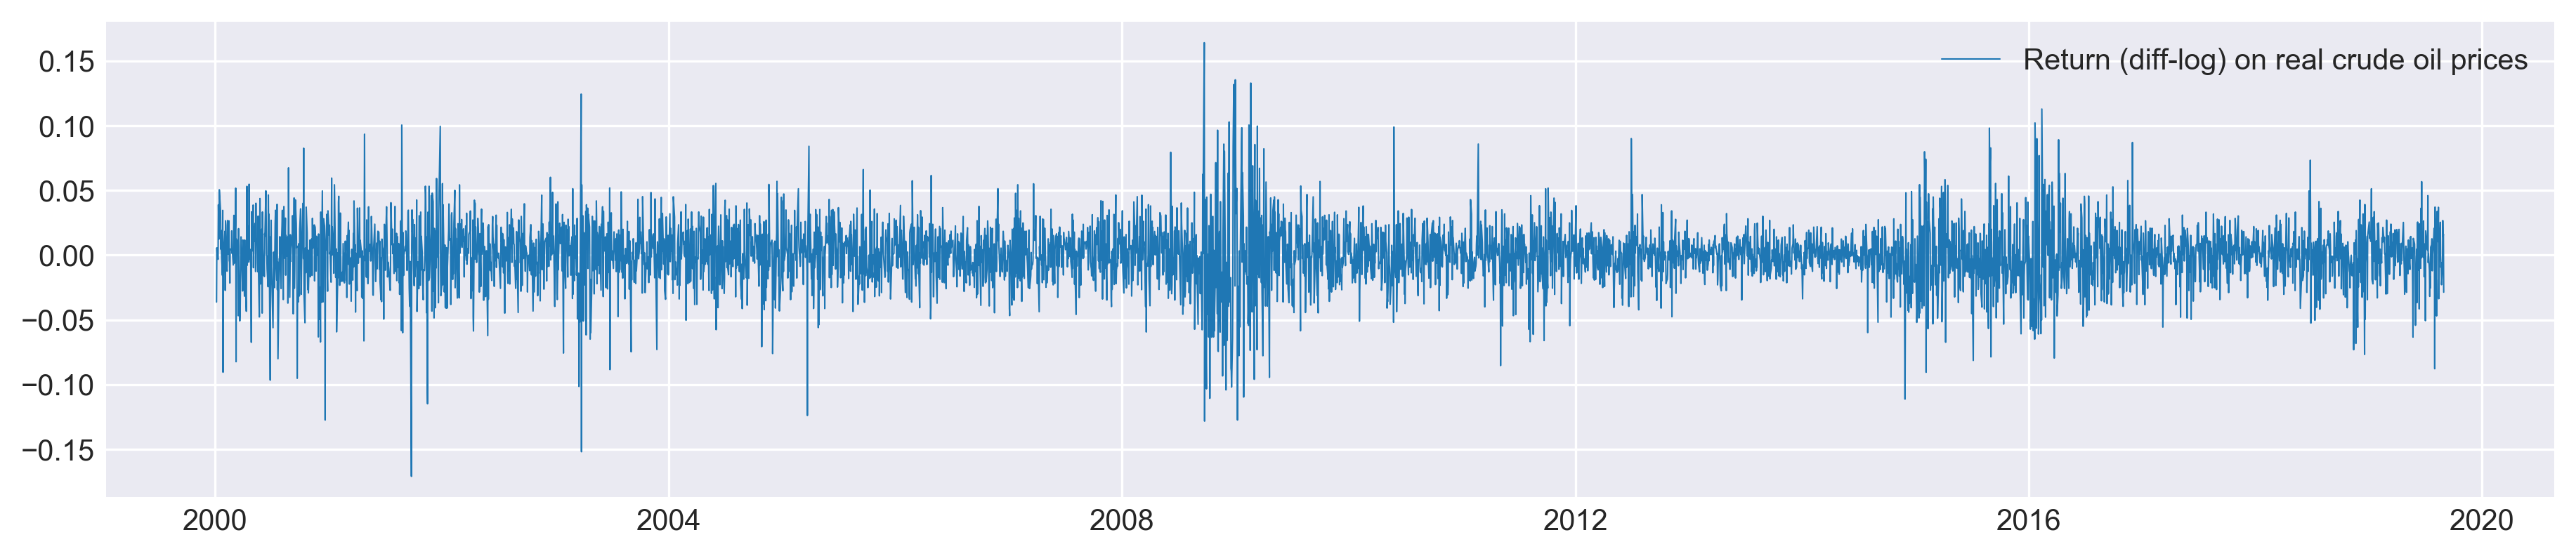

In [250]:
plt.plot(df_wti_return, linewidth=0.5, label="Return (diff-log) on real crude oil prices")
plt.legend()
plt.show()

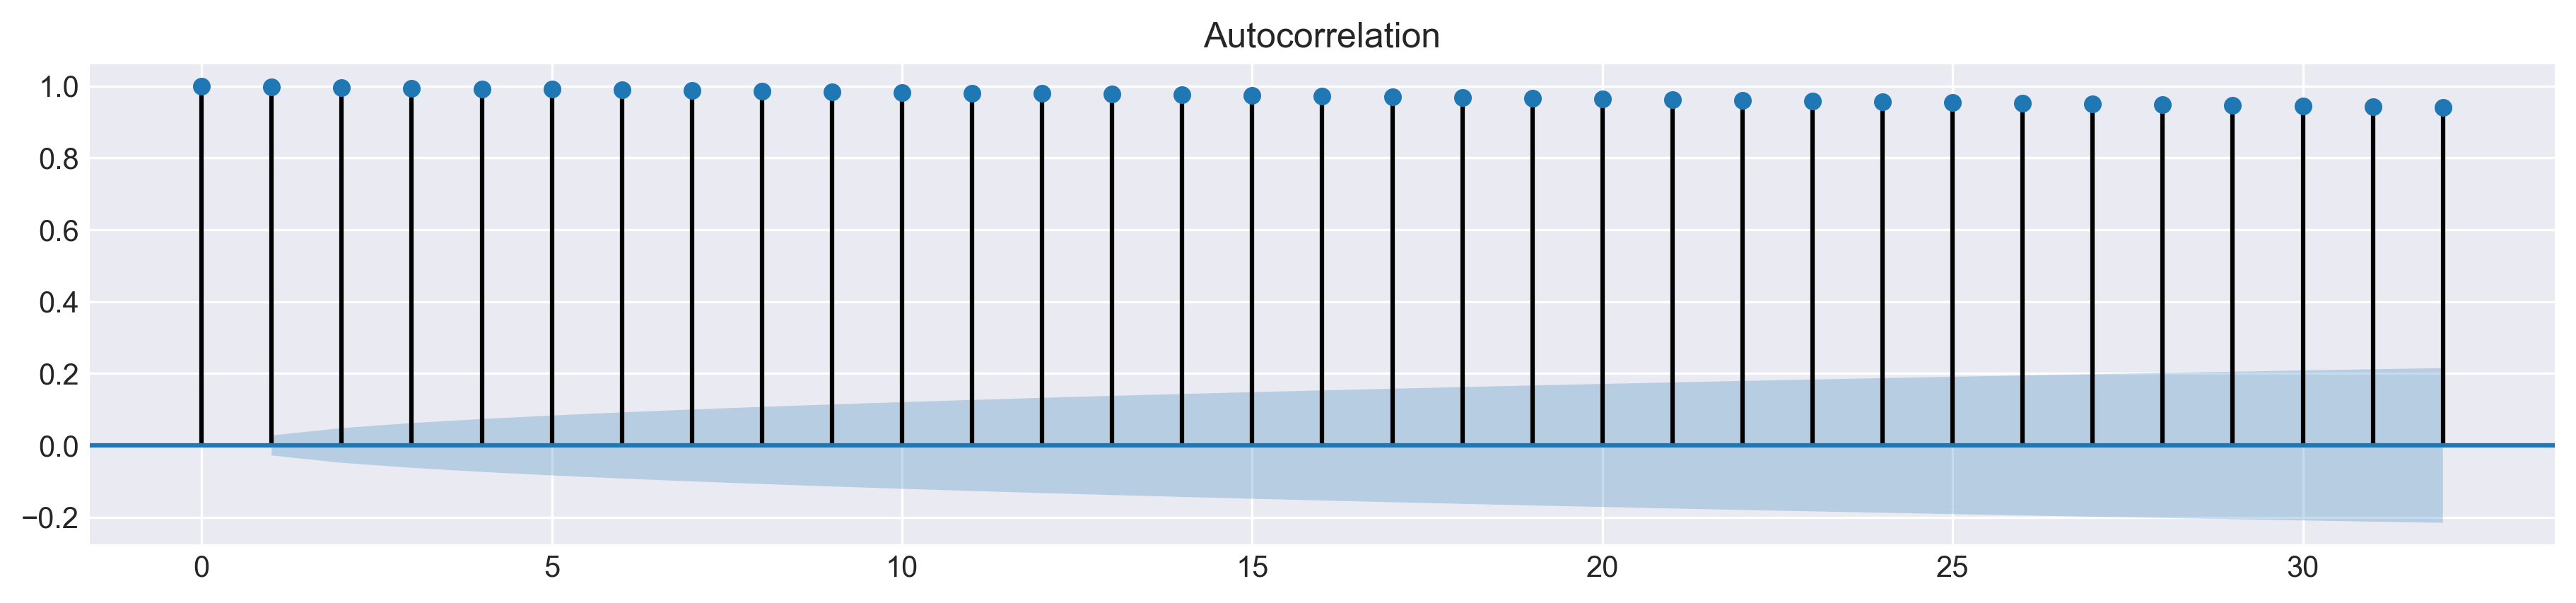

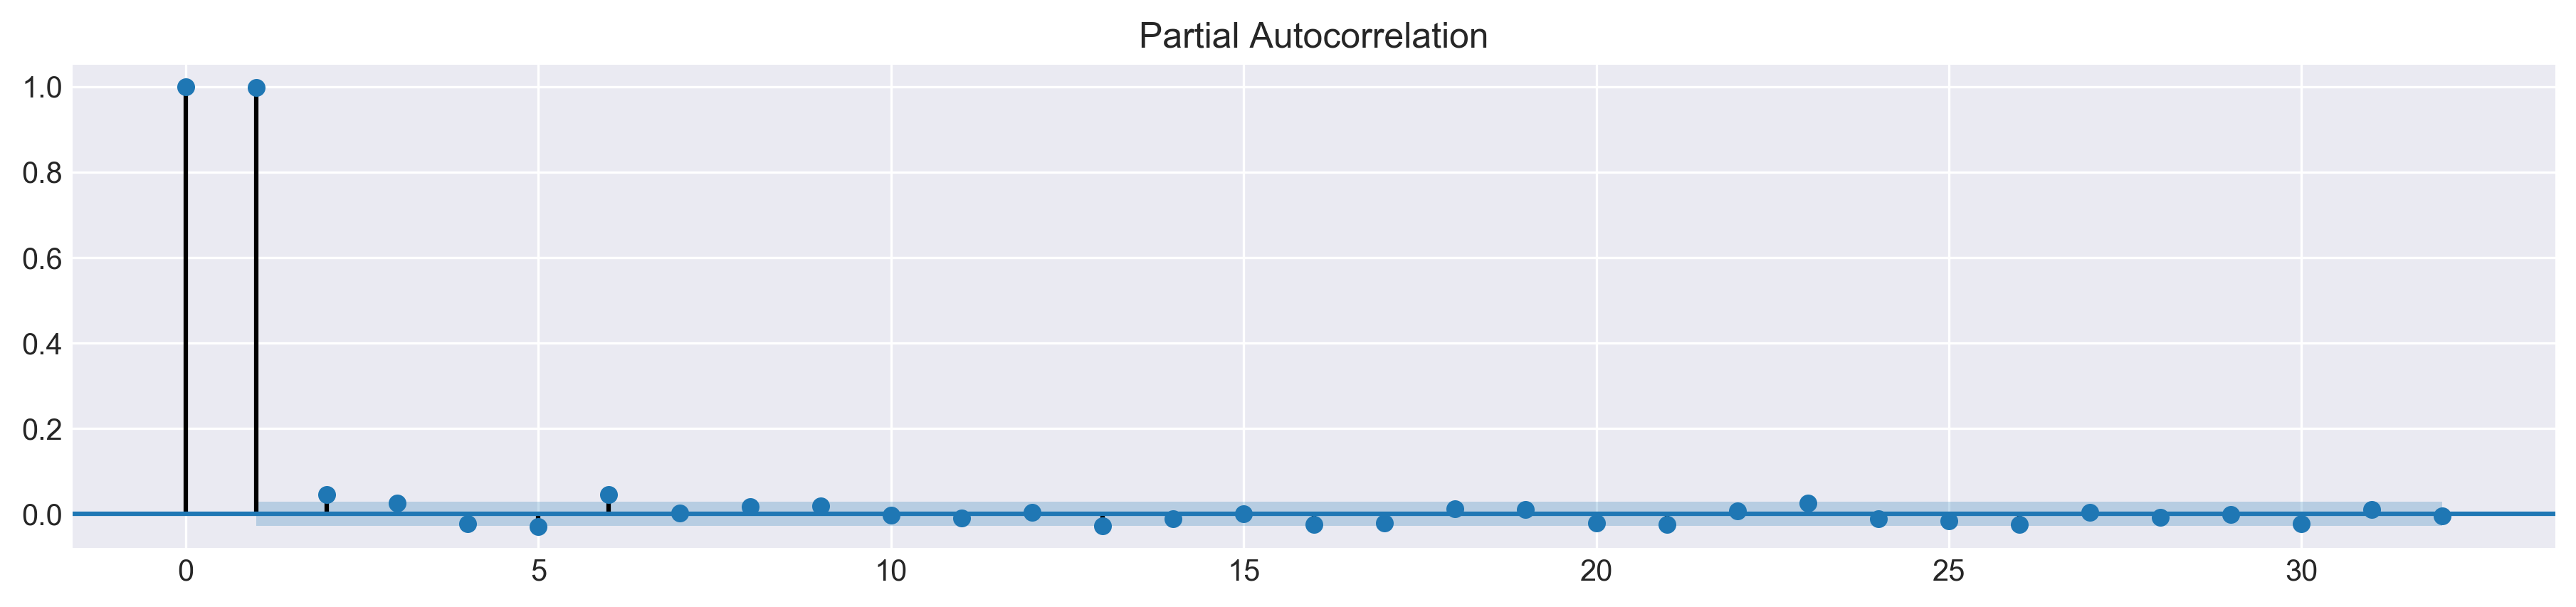

In [223]:
# For real prices.
sm.tsa.graphics.plot_acf(df_wti_real.dropna().values, lags=32)
plt.show()
sm.tsa.graphics.plot_pacf(df_wti_real.dropna(), lags=32)
plt.show()

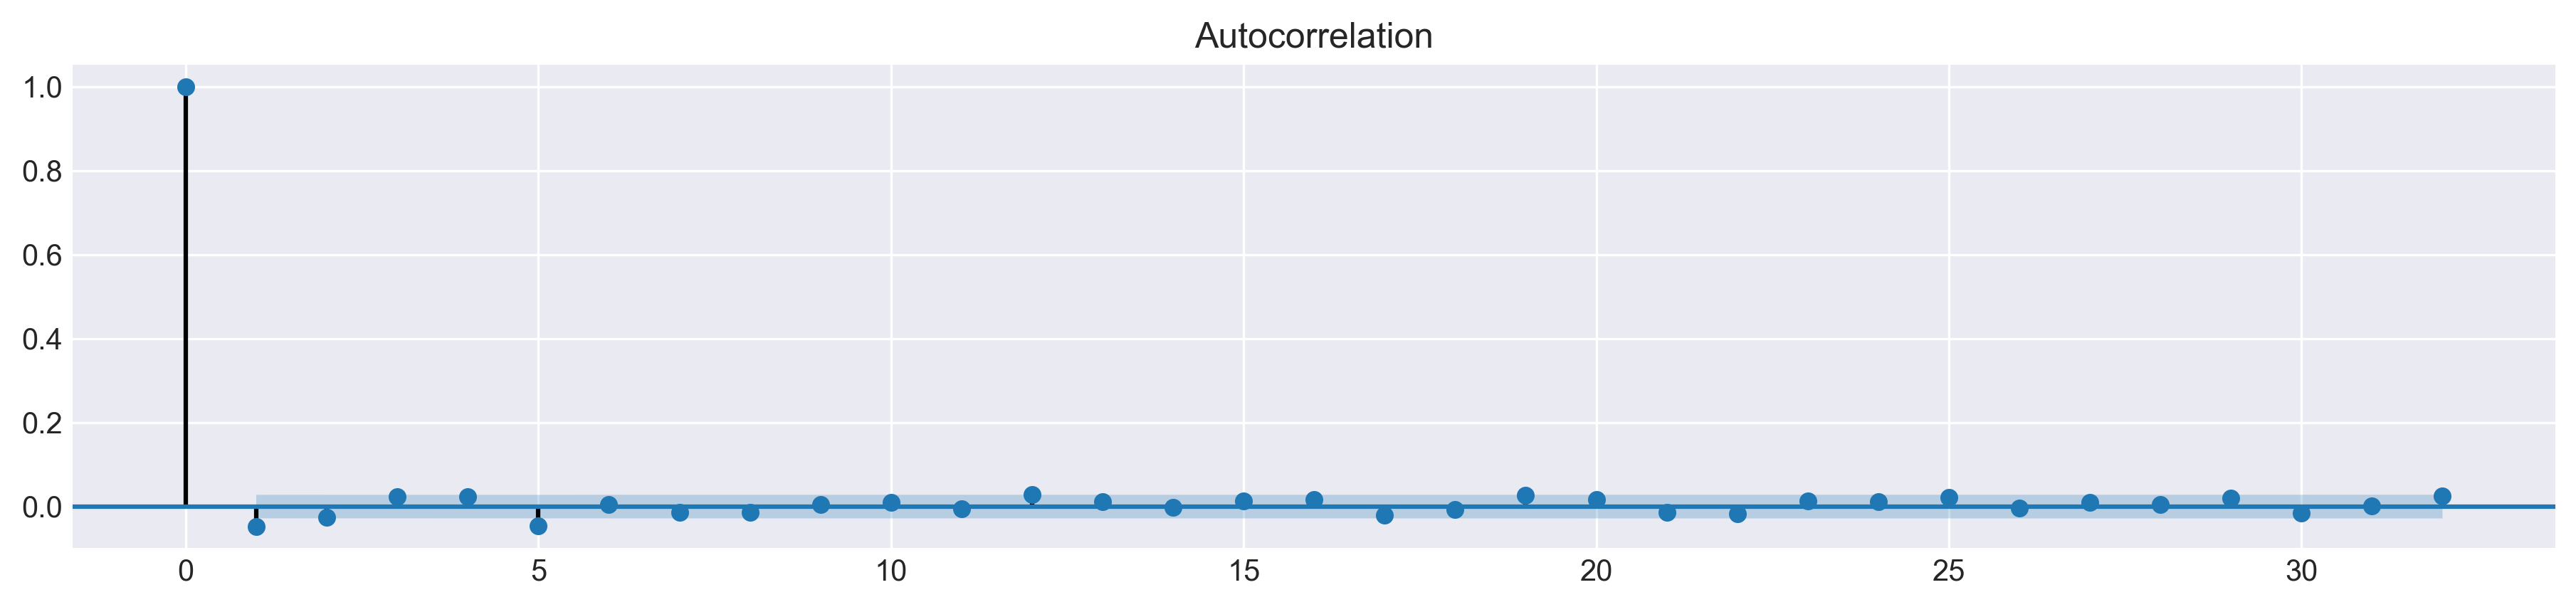

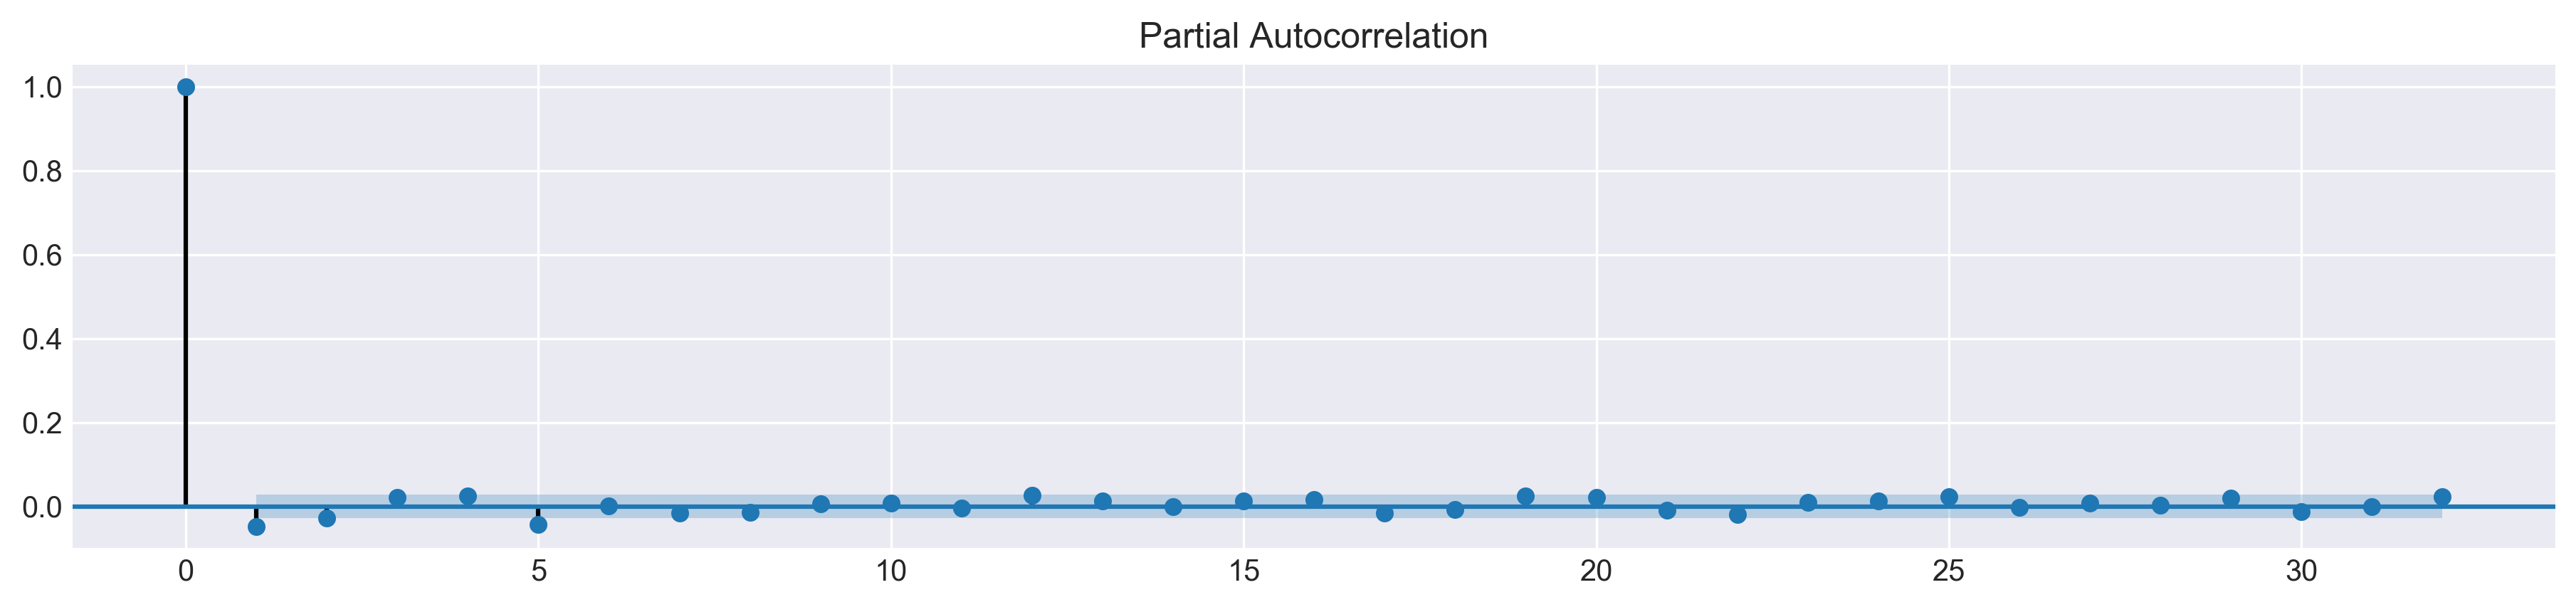

In [232]:
# For change on real prices.
sm.tsa.graphics.plot_acf(df_wti_real.diff().dropna().values, lags=32)
plt.show()
sm.tsa.graphics.plot_pacf(df_wti_real.diff().dropna(), lags=32)
plt.show()

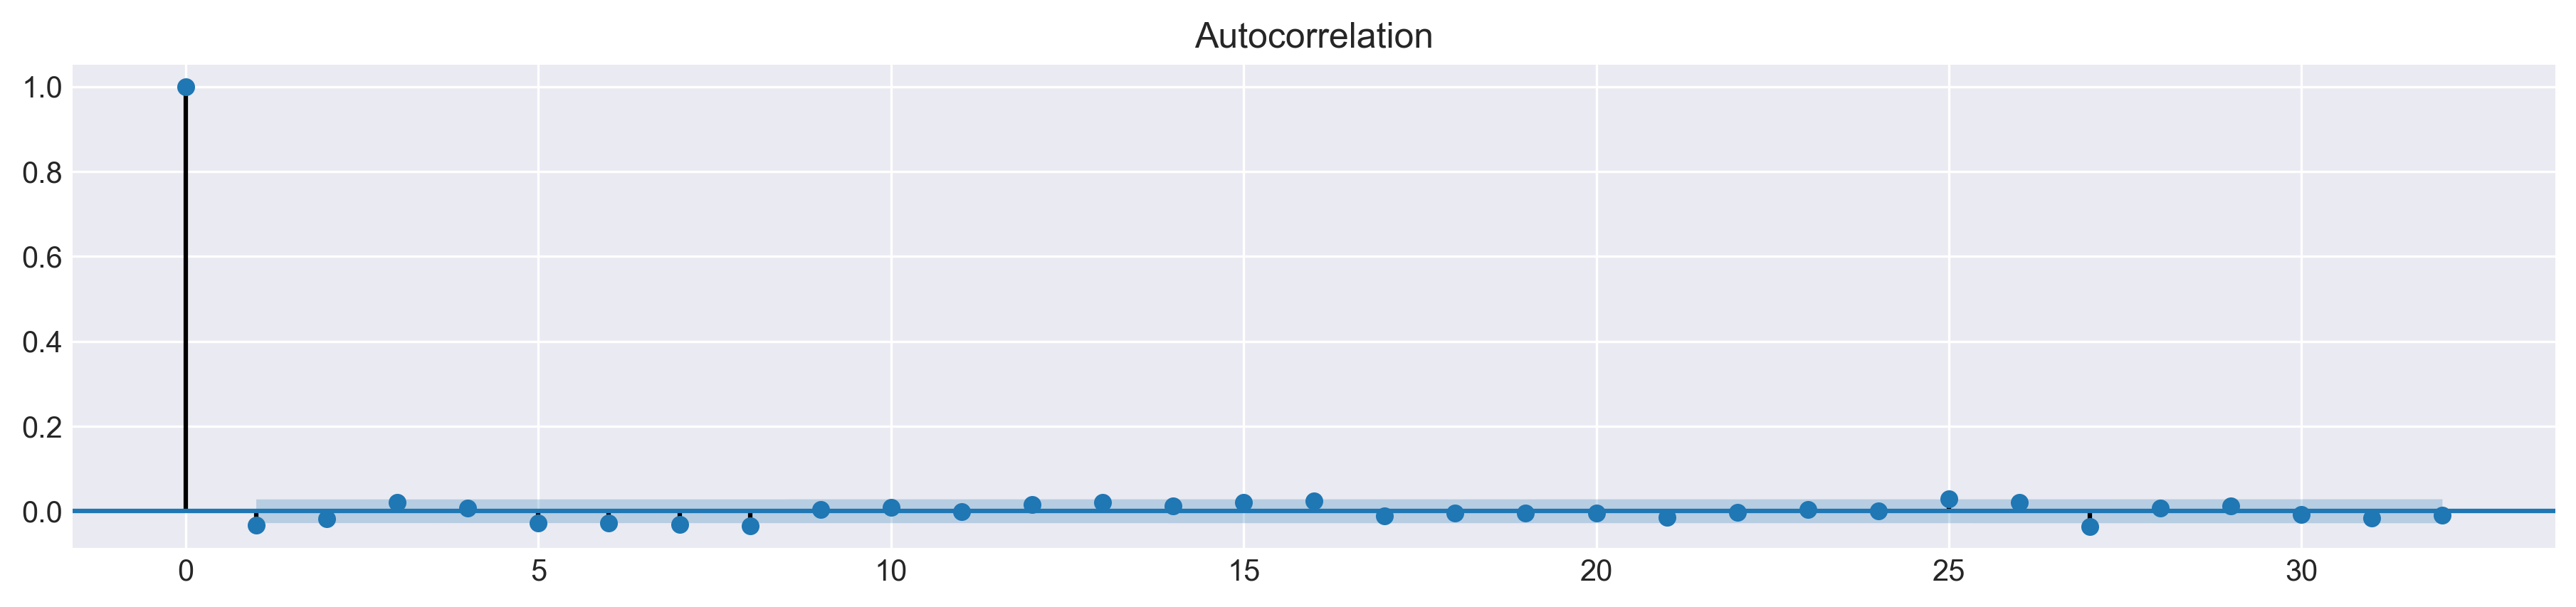

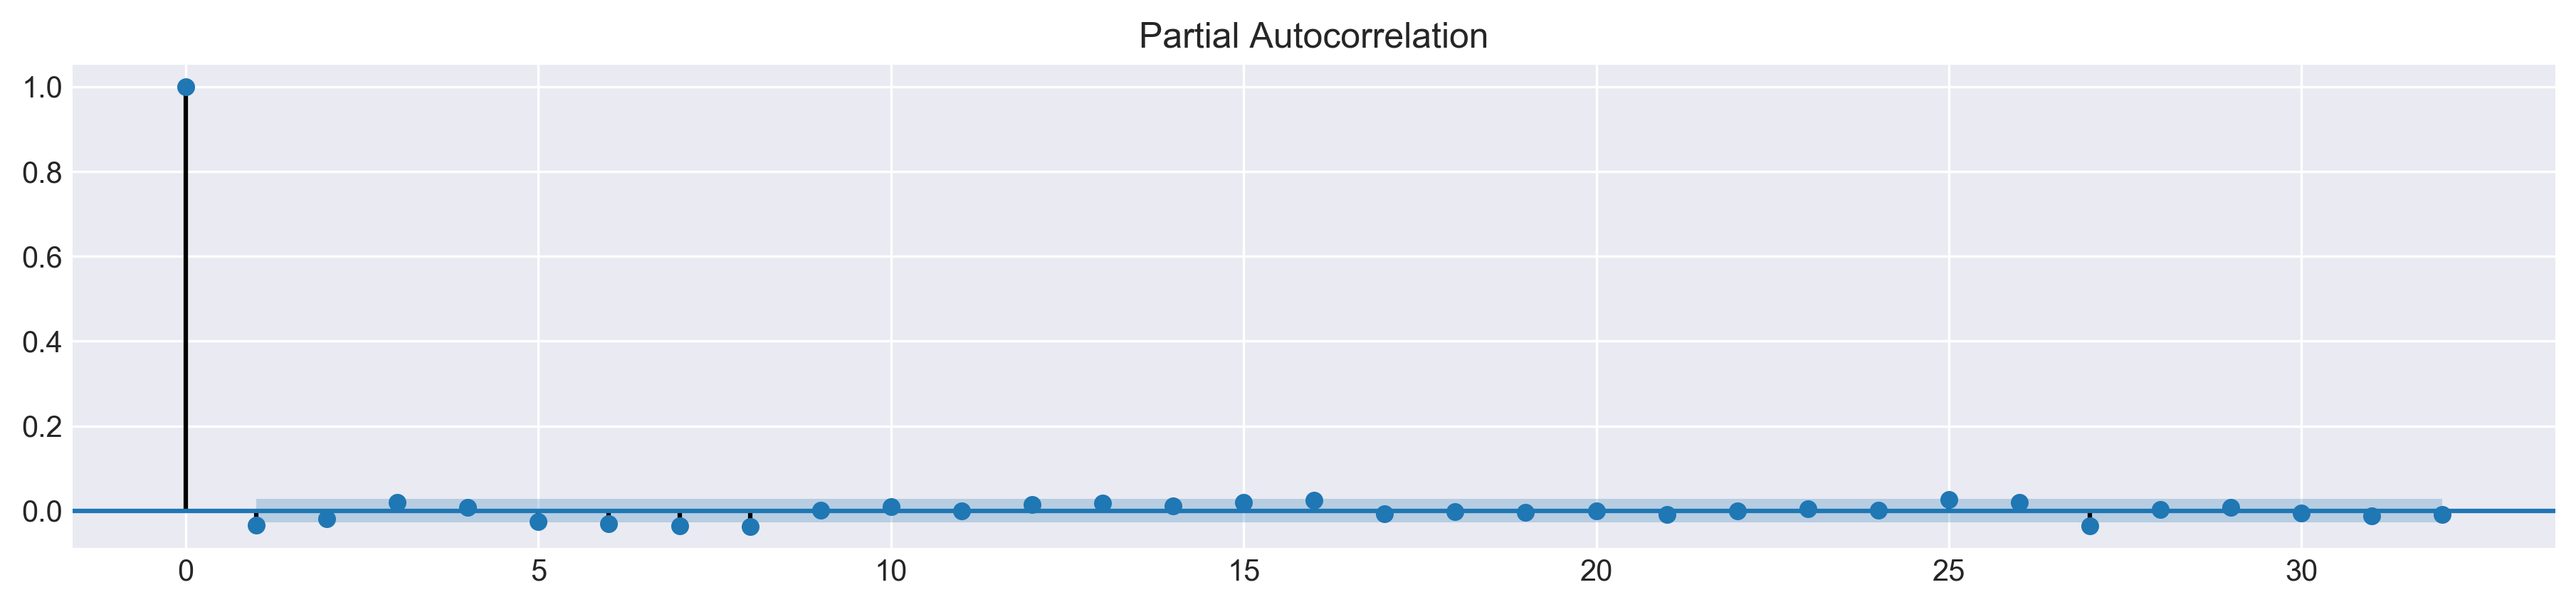

In [224]:
# For returns on real prices.
sm.tsa.graphics.plot_acf(df_wti_return.dropna().values, lags=32)
plt.show()
sm.tsa.graphics.plot_pacf(df_wti_return.dropna(), lags=32)
plt.show()

In [247]:
# Save generated results
df_wti_real.dropna().to_csv("../data/ready_to_use/wti_crude_oil_price_real.csv")
df_wti_return.dropna().to_csv("../data/ready_to_use/wti_crude_oil_return_real.csv")